In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model


In [2]:
X_train,X_test,Y_train, Y_test = load_data()
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

lab_data = rgb2lab(Y_train)
print (lab_data.shape) 
#lab_data,mean_dat,std_dat = normalise_train(lab_data)

0
(3980, 64, 64, 1)
(996, 64, 64, 1)
(3980, 64, 64, 3)
(996, 64, 64, 3)
(3980, 64, 64, 3)


(3908, 64, 64, 1)
(64, 64, 1)
(64, 64, 1)


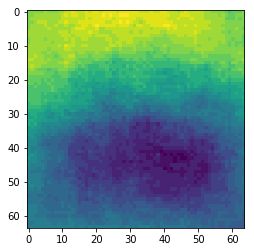

(977, 64, 64, 1)
(3908, 64, 64, 1)


In [3]:
X_train,mean_image,std_image = normalise_train(X_train)
print (X_train.shape)
print (mean_image.shape)
print (std_image.shape)
plt.imshow(mean_image[:,:,0].astype('uint8'))
plt.show()
X_test = normalise_test(X_test,mean_image,std_image)
print(X_test.shape)
print (X_train.shape)

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 64, 64,1])
Y = tf.placeholder(tf.float32 ,[None , 64,64,3])
is_training = tf.placeholder(tf.bool)

with tf.variable_scope("model") as scope:
    y_out = complex_pokemon_model(X)
    loss = tf.sqrt(tf.nn.l2_loss(y_out-Y))
    optimiser = tf.train.AdamOptimizer(1e-4)
    train_step = optimiser.minimize(loss)

    scope.reuse_variables()
    test_model = complex_pokemon_model(X,False)
    loss_test = tf.sqrt(tf.nn.l2_loss(test_model - Y))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 32
def train_epoch(data, target):
    sizee = data.shape[0]
    for i in range(sizee//batch_size):
        feed_dict = {Y:   (target[i*batch_size:batch_size*i+batch_size]), X: data[i*batch_size:batch_size*i+batch_size],is_training:True}
        losses,_ = sess.run([loss,train_step],feed_dict)
        if(i%5==0):
            print (losses)

  

def val_result(data, target):
    sizee = data.shape[0]
    for i in range(sizee//batch_size):
        feed_dict = {Y:  (target[i*batch_size:batch_size*i+batch_size]), X: data[i*batch_size:batch_size*i+batch_size],is_training:False}
        losses = sess.run([loss_test],feed_dict)
        if(i%5 ==0):
            print (losses)

num_epochs = 10
for i in range(num_epochs):
    train_epoch(X_train, Y_train)
    val_result(X_test, Y_test)

    



58762.1
51912.4
50740.0
[53079.75]
58672.3
51880.9
50720.4
[53063.273]
58656.4
51868.5
50707.9
[53053.137]
58645.9
51858.4
50700.2
[53044.531]
58636.4
51852.1
50693.2
[53036.445]
58629.5
51847.6
50686.9
[53030.137]
58626.0
51841.8
50683.3
[53025.23]
58621.7
51839.5
50678.7
[53021.449]
58620.2
51837.0
50673.8
[53018.461]
58617.2
51834.3
50671.2
[53016.098]


(10, 64, 64, 1)
(10, 64, 64, 1)
34289.7
(10, 64, 64, 3)


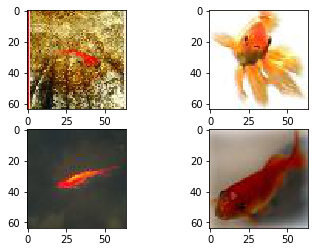

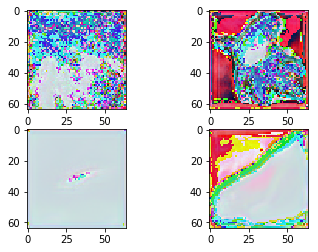

In [17]:
### Image visualisation
import matplotlib.pyplot as plt
import numpy.random as rnd

#def rgb2gray2(rgb):
 #   a = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
  #  return a

rand_indices = np.random.choice(400,10)
sample_images = X_train[rand_indices]
samp = Y_train[rand_indices]
print (sample_images.shape)
grayed_sample_images = (sample_images)
print (grayed_sample_images.shape)

feed_dict = {X:grayed_sample_images[:,:,:],Y:samp,is_training:True}
model_generated_images = sess.run([test_model,loss_test],feed_dict)
print (model_generated_images[1])
print(model_generated_images[0].shape)

def show_images(images,gray = False):

    
    if(gray):
        plt.subplot(221)
        plt.imshow(images[0],cmap = plt.get_cmap('gray'))
        plt.subplot(222)
        plt.imshow(images[1], cmap = plt.get_cmap('gray'))
        plt.subplot(223)
        plt.imshow(images[2], cmap = plt.get_cmap('gray'))
        plt.subplot(224)
        plt.imshow(images[3], cmap = plt.get_cmap('gray'))
    else :
        plt.subplot(221)
        plt.imshow(images[0]);
        plt.subplot(222)
        plt.imshow(images[1])
        plt.subplot(223)
        plt.imshow(images[2])
        plt.subplot(224)
        plt.imshow(images[3])

    plt.show()
    
    
show_images((samp))
#show_images(grayed_sample_images,gray = True)
show_images((model_generated_images[0]) )

    

In [3]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 64, 64,1])
Y = tf.placeholder(tf.float32 ,[None , 64,64,2])
is_training = tf.placeholder(tf.bool)

X_train = lab_data[...,0:1]
Y_train = lab_data[...,1:3]
print (X_train.shape)
print (Y_train.shape)

with tf.variable_scope("model") as scope:
    y_out = simpler_model(X)
    loss = tf.sqrt(tf.reduce_mean(tf.square(y_out-Y)))
    optimiser = tf.train.AdamOptimizer(1e-1)
    train_step = optimiser.minimize(loss)

    scope.reuse_variables()
    test_model = simpler_model(X,False)
    loss_test = tf.sqrt(tf.nn.l2_loss(test_model - Y))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 64
def train_epoch(data, target):
    sizee = data.shape[0]
    for i in range(sizee//batch_size):
        feed_dict = {Y:   (target[i*batch_size:batch_size*i+batch_size]), X: data[i*batch_size:batch_size*i+batch_size],is_training:True}
        losses,_ = sess.run([loss,train_step],feed_dict)
        if(i%5==0):
            print (losses)

  

def val_result(data, target):
    sizee = data.shape[0]
    for i in range(sizee//batch_size):
        feed_dict = {Y:  (target[i*batch_size:batch_size*i+batch_size]), X: data[i*batch_size:batch_size*i+batch_size],is_training:False}
        losses = sess.run([loss_test],feed_dict)
        if(i%5 ==0):
            print (losses)

num_epochs = 2
for i in range(num_epochs):
    train_epoch(X_train, Y_train)
    print ("Next Epoch")
    #val_result(X_test, Y_test)

    


(3980, 64, 64, 1)
(3980, 64, 64, 2)
17.6995
16.046
15.0251
13.8375
16.1944
14.7184
12.8158
13.7221
14.2633
14.0254
14.3535
13.3073
16.1426
Next Epoch
15.5997
14.5751
14.5362
13.9136
15.6624
14.8479
12.8561
13.6986
14.3951
13.9696
14.222
13.3169
16.1442
Next Epoch


(10, 64, 64, 1)
(10, 64, 64, 2)
(10, 64, 64, 3)
3219.27
(10, 64, 64, 2)


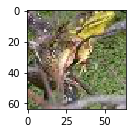

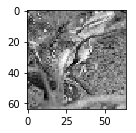

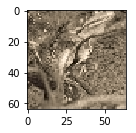

In [10]:
### Image visualisation
import matplotlib.pyplot as plt
import numpy.random as rnd

#def rgb2gray2(rgb):
 #   a = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
  #  return a

rand_indices = np.random.choice(400,10)
sample_images = X_train[rand_indices]
samp = Y_train[rand_indices]
original_data = lab_data[rand_indices]
print (sample_images.shape)
print (samp.shape)
print (original_data.shape)

feed_dict = {X:sample_images,Y:samp,is_training:True}
model_generated_images = sess.run([test_model,loss_test],feed_dict)
print (model_generated_images[1])
print(model_generated_images[0].shape)

def show_images(images,gray = False):

    
    if(gray):
        plt.subplot(221)
        plt.imshow(images,cmap = plt.get_cmap('gray'))
        #plt.subplot(222)
        #plt.imshow(images[1], cmap = plt.get_cmap('gray'))
        #plt.subplot(223)
        #plt.imshow(images[2], cmap = plt.get_cmap('gray'))
        #plt.subplot(224)
        #plt.imshow(images[3], cmap = plt.get_cmap('gray'))
    else :
        plt.subplot(221)
        plt.imshow(images);
        #plt.subplot(222)
        #plt.imshow(images[1])
        #plt.subplot(223)
        #plt.imshow(images[2])
        #plt.subplot(224)
        #plt.imshow(images[3])

    plt.show()
    
show_images(lab2rgb(original_data[0,:,:,:] ) )
original_data[...,1:3] = model_generated_images[0]
show_images(original_data[0,:,:,0],gray = True)
show_images(lab2rgb(original_data[0,:,:,:]))

    